In [106]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(15)
torch.set_default_dtype(torch.float64)

In [108]:
def u_exact(x:torch.Tensor):
    # u_g = x**3/(0.01 + x**4)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    return u_g

def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

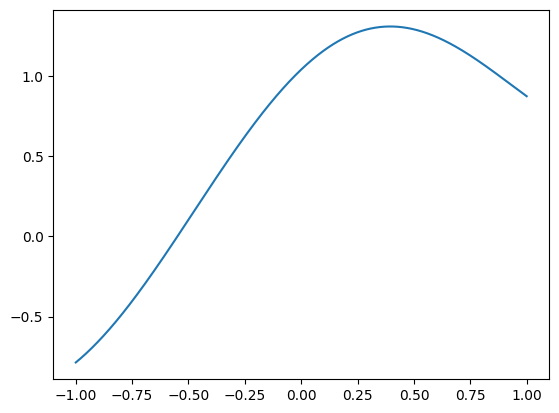

In [109]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1).to(device)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1).to(device)
u_eval = u_exact(x_eval)
plt.plot(x_eval.cpu(), u_eval.cpu(), label='Exact solution')

In [110]:
class SinActivation(torch.nn.Module):
    def __init__(self) -> None:
        super(SinActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)
    
class FullyConnectedNN(torch.nn.Module):
    def __init__(self, x_train, u_train, layers, kappa, low_bound_xtrain, up_bound_xtrain, actv=0) -> None:
        super(FullyConnectedNN, self).__init__()

        self.u_scale = torch.sqrt(torch.mean(torch.abs(u_train**2)))
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.lb, self.up = low_bound_xtrain, up_bound_xtrain
        self.n_layers = len(layers)

        self.kappa = kappa
        self.first_activation = [torch.nn.Tanh(), SinActivation()][actv]
        self.activation = torch.nn.Tanh()

        self.weights, self.biases = self._initialize_weights(layers)

    def _initialize_weights(self, layers):
        weights, biases = [], []
        for i in range(len(layers)-1):
            W = torch.nn.Parameter(self._weight_matrix(size_in=layers[i], size_out=layers[i+1]))
            b = torch.nn.Parameter(torch.zeros(layers[i+1], 1))
            weights.append(W)
            biases.append(b)
        return torch.nn.ParameterList(weights), torch.nn.ParameterList(biases)
    
    def _weight_matrix(self, size_in, size_out):
        std = np.sqrt(2/(size_in + size_out))
        return torch.nn.init.trunc_normal_(torch.empty(size_in, size_out), std=std)
    
    def forward(self, x):
        weights = self.weights
        biases = self.biases
        x_normalized = 2*(x - self.lb)/(self.up - self.lb) - 1

        W, b = weights[0], biases[0]
        x_forwarded = self.first_activation(self.kappa*(x_normalized @ W) + b.T)

        for i in range(1, self.n_layers-2):
            W, b = weights[i], biases[i]
            x_forwarded = self.activation(self.kappa*(x_forwarded @ W) + b.T)

        W, b = weights[-1], biases[-1]
        u_theta = x_forwarded @ W + b.T
        return u_theta
    
    def train(self, n_iter):
        criterion = torch.nn.MSELoss()
        model_optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)

        for iter_i in range(n_iter): 
            model_optimizer.zero_grad()

            u_pred = self.forward(self.x_train)
            loss = criterion(u_pred, self.u_train)*self.loss_scale 
            
            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iter {iter_i}, Loss: {loss.item()}')

    def predict(self, x):
        return self.u_scale*self.forward(x)

In [111]:
model1 = FullyConnectedNN(x_train=x_train, u_train=u_train, layers=[1, 20, 20, 20, 1], kappa=1, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=0).to(device)
model1.train(10000)
u_pred0 = model1.predict(x_eval)

Iter 0, Loss: 0.8906338183877667
Iter 100, Loss: 0.06940034799497227
Iter 200, Loss: 0.04912829943071736
Iter 300, Loss: 0.025195513818802705
Iter 400, Loss: 0.010732611423324023
Iter 500, Loss: 0.0063412267221017015
Iter 600, Loss: 0.005300862875789852
Iter 700, Loss: 0.004758218884978879
Iter 800, Loss: 0.004282630752951083
Iter 900, Loss: 0.0038431255288524165
Iter 1000, Loss: 0.0034383881808759975
Iter 1100, Loss: 0.0030671704285405157
Iter 1200, Loss: 0.002726983308187727
Iter 1300, Loss: 0.0024146674390365906
Iter 1400, Loss: 0.0021270544287588307
Iter 1500, Loss: 0.0018614340111672207
Iter 1600, Loss: 0.001615780519183214
Iter 1700, Loss: 0.0013887883701749878
Iter 1800, Loss: 0.0011797921319018124
Iter 1900, Loss: 0.0009886325991367764
Iter 2000, Loss: 0.0008155015918235079
Iter 2100, Loss: 0.0006607721427324097
Iter 2200, Loss: 0.0005248087751969369
Iter 2300, Loss: 0.0004077612611414185
Iter 2400, Loss: 0.0003093709017352519
Iter 2500, Loss: 0.00022884086370522844
Iter 2600, 

In [112]:
u0 = model1.predict(x_train).detach()
error_1 = u_train - u0
kappa2 = calculate_kappa(error_1)

print(f'Le coefficient kappa2 vaut: {kappa2}')

model2 = FullyConnectedNN(x_train=x_train, u_train=error_1, layers=[1, 20, 20, 20, 1], kappa=kappa2, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=1).to(device)
model2.train(25000)
u_pred1 = model2.predict(x_eval)
u_p = u_pred0 + u_pred1

Le coefficient kappa2 vaut: 24
Iter 0, Loss: 1.3220444986282817e-06
Iter 100, Loss: 3.833831913798192e-07
Iter 200, Loss: 1.4985439299257352e-07
Iter 300, Loss: 7.007253582540338e-08
Iter 400, Loss: 4.878867320669988e-08
Iter 500, Loss: 4.005642263207453e-08
Iter 600, Loss: 3.3951081892331455e-08
Iter 700, Loss: 2.853725609210145e-08
Iter 800, Loss: 2.450812345574475e-08
Iter 900, Loss: 2.1585691216539416e-08
Iter 1000, Loss: 1.922453326970435e-08
Iter 1100, Loss: 1.7515254138760567e-08
Iter 1200, Loss: 1.6252669040789468e-08
Iter 1300, Loss: 1.5282728214853644e-08
Iter 1400, Loss: 1.4249313128395256e-08
Iter 1500, Loss: 1.3305827082836692e-08
Iter 1600, Loss: 1.2414575624182648e-08
Iter 1700, Loss: 1.1727573214168721e-08
Iter 1800, Loss: 1.105626304519897e-08
Iter 1900, Loss: 1.0648399869262874e-08
Iter 2000, Loss: 9.960570814183756e-09
Iter 2100, Loss: 9.377360544701607e-09
Iter 2200, Loss: 8.648113027348477e-09
Iter 2300, Loss: 8.050053947817205e-09
Iter 2400, Loss: 7.71301102071740

In [113]:
x_train2 = torch.linspace(-1.02, 1.02, 4801).reshape(-1,1).to(device)
u_train2 = u_exact(x_train2)
error_2 = u_train2 - model1.predict(x_train2).detach() - model2.predict(x_train2).detach()
kappa3 = calculate_kappa(error_2)

print(f'Le coefficient kappa3 vaut: {kappa3}')

model3 = FullyConnectedNN(x_train=x_train2, u_train=error_2, layers=[1, 30, 30, 30, 1], kappa=kappa3, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=1).to(device)
model3.train(10000)
u_pred2 = model3.predict(x_eval)
u_p2 = u_p + u_pred2

Le coefficient kappa3 vaut: 762
Iter 0, Loss: 3.3564817755724736e-09


Iter 100, Loss: 2.967411306245337e-09
Iter 200, Loss: 2.9474290144722864e-09
Iter 300, Loss: 3.112992535828231e-09
Iter 400, Loss: 2.60185090840493e-09
Iter 500, Loss: 2.494000226676808e-09
Iter 600, Loss: 2.602476109392239e-09
Iter 700, Loss: 2.561747480515493e-09
Iter 800, Loss: 2.4257925471985847e-09
Iter 900, Loss: 2.555392715170893e-09
Iter 1000, Loss: 2.494996718454955e-09
Iter 1100, Loss: 2.199504803056478e-09
Iter 1200, Loss: 2.337690478364107e-09
Iter 1300, Loss: 2.1553724457014593e-09
Iter 1400, Loss: 2.242471949809481e-09
Iter 1500, Loss: 2.094078209882519e-09
Iter 1600, Loss: 2.372497708823889e-09
Iter 1700, Loss: 2.142613055030894e-09
Iter 1800, Loss: 2.0540799883316716e-09
Iter 1900, Loss: 1.9258519677505574e-09
Iter 2000, Loss: 1.970653448023434e-09
Iter 2100, Loss: 2.0385866334563946e-09
Iter 2200, Loss: 1.8836087964700554e-09
Iter 2300, Loss: 1.969381829667763e-09
Iter 2400, Loss: 1.8659024044402752e-09
Iter 2500, Loss: 2.048303177928078e-09
Iter 2600, Loss: 1.99651047

Text(0.5, 1.0, 'Residue order 2')

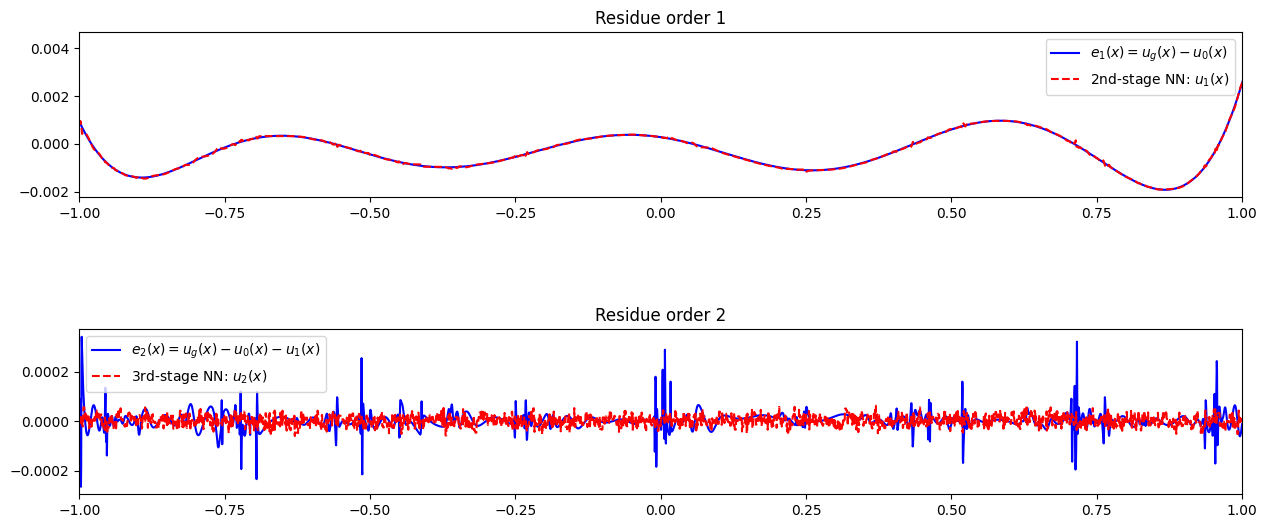

In [114]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_train.cpu(), error_1.cpu().detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[0].plot(x_train.cpu(), model2.predict(x_train).cpu().detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[0].set_xlim(-1, 1)
axes[0].legend()
axes[0].set_title('Residue order 1')

axes[1].plot(x_train2.cpu(), error_2.cpu().detach(), 'b-', label=r'$e_2(x) = u_g(x) - u_0(x) - u_1(x)$')
axes[1].plot(x_train2.cpu(), model3.predict(x_train2).cpu().detach(), 'r--', label=r'3rd-stage NN: $u_2(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 2')

In [115]:
error_u = np.linalg.norm(u_eval.cpu() - u_pred0.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u2 = np.linalg.norm(u_eval.cpu() - u_p.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u3 = np.linalg.norm(u_eval.cpu() - u_p2.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')

Error of order 1: 0.0008773045557111993
Error of order 2: 3.453425718909238e-05
Error of order 3: 3.9997343699735986e-05
